### Data Loading & Preprocessing

In [22]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Initialize `nltk`

In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nidhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Fake News Dataset

In [3]:
df_fake = pd.read_csv("fake_news_dataset/Fake.csv")
df_real = pd.read_csv("fake_news_dataset/True.csv")

# adding labels
df_fake["label"] = 0
df_real["label"] = 1

# combine and shuffle
df = pd.concat([df_fake, df_real], axis = 0)
df = df.sample(frac=1).reset_index(drop=True)

df = df[['text', 'label']]
print(df.head())

                                                text  label
0  After he previously denied knowing about the d...      0
1  Things just keep going from bad to worse in re...      0
2  As federal agents prepare to scour roughly 650...      0
3  The lyrics seem to have been inspired by Donal...      0
4  Is it not enough that Hillary has compromised ...      0


### Text Cleaning

In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\[.*&?\]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\w*\d\w*", "", text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)
df["text"] = df["text"].apply(clean_text)

### Tokenization & Padding

In [5]:
max_words = 5000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["text"])
sequences = tokenizer.texts_to_sequences(df["text"])
X = pad_sequences(sequences, maxlen=max_len)
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 128)         98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 759,457
Trainable params: 759,457
Non-trainable params: 0
__________________________________________________

### Evaluate the Model

In [7]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

281/281 [==============================] - 134s 466ms/step
Accuracy:  0.9993318485523385
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4686
           1       1.00      1.00      1.00      4294

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



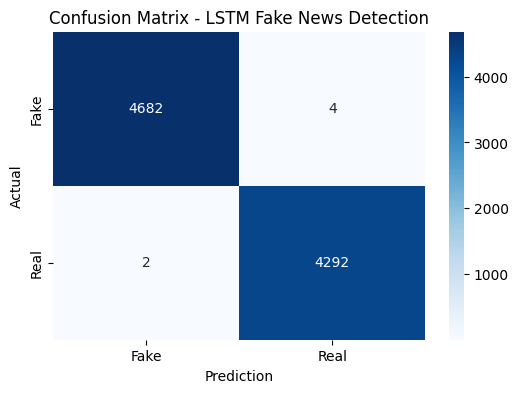

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM Fake News Detection")
plt.show()

In [10]:
# ✅ Accuracy on training data
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)

# ✅ Accuracy on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Interpretation
if train_acc - test_acc > 0.10:  # more than 10% gap
    print("⚠️ Model is likely overfitting.")
else:
    print("✅ Model is generalizing well.")

Training Accuracy: 99.97%
Test Accuracy: 99.93%
✅ Model is generalizing well.


### Models & their comparisons

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [12]:
# using TF-IDF feature because using tokenizers was a type for LSTM

# Ensuring text data is in string format
X_train_text = [str(x) for x in X_train]
X_test_text = [str(x) for x in X_test]

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier()
}

In [23]:
results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred) * 100
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}%")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 80)

Logistic Regression Accuracy: 98.94%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4686
           1       0.99      0.99      0.99      4294

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--------------------------------------------------------------------------------
SVM Accuracy: 99.49%
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4686
           1       0.99      1.00      0.99      4294

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--------------------------------------------------------------------------------
Decision Tree Accuracy: 99.57%
Decision Tree Classificat

In [16]:
results["LSTM"] = 99.93

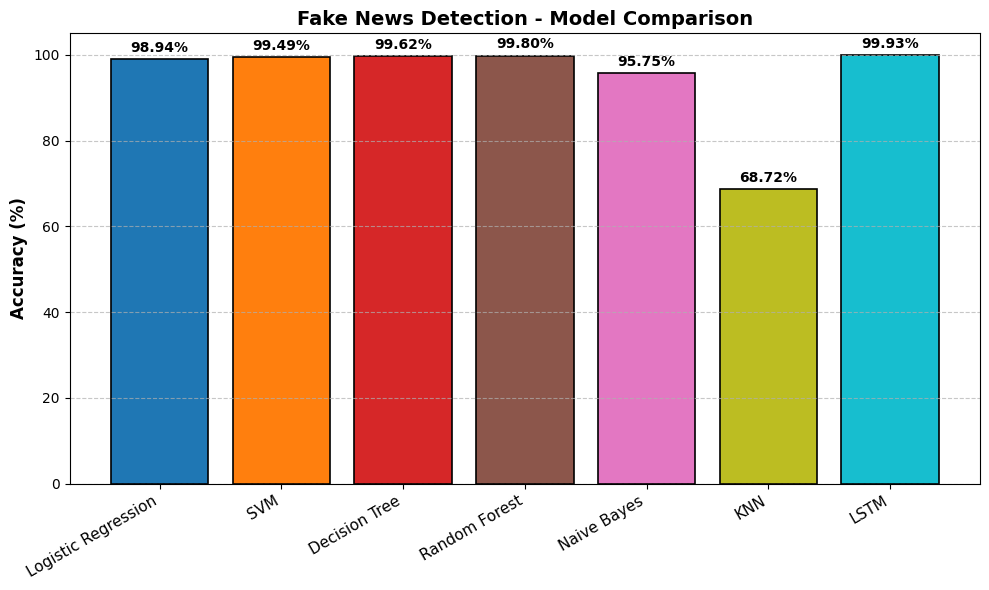

In [18]:
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=colors, edgecolor='black', linewidth=1.2)

plt.ylabel("Accuracy (%)", fontsize=12, fontweight='bold')
plt.title("Fake News Detection - Model Comparison", fontsize=14, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values on top of bars
for bar, value in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, value + 1, f"{value:.2f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')

plt.show()